In [15]:
import torch
from torch import nn
import matplotlib.pyplot as plt
# Check PyTorch version
torch.__version__

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [17]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [18]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

In [19]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1,
                                      dtype=torch.float)
    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.linear_layer(x) # <- this is the linear regression formula (y = m*x + b)

In [20]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
# list(model_0.parameters())

# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))


model_0.to(device)

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = torch.empty(epochs, requires_grad=False).to(device)
test_loss_values = torch.empty(epochs, requires_grad=False).to(device)
epoch_count = torch.empty(epochs, requires_grad=False).to(device)

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    # if epoch % 10 == 0:
    with torch.inference_mode():
        test_preds = model_0(X_test)
        test_loss = loss_fn(test_preds, y_test)
        print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")
        epoch_count[[epoch]] = epoch
        test_loss_values[[epoch]] = test_loss
        train_loss_values[[epoch]] = loss

Epoch: 0 | MAE Train Loss: 0.5551779866218567 | MAE Test Loss: 0.5739762187004089 
Epoch: 1 | MAE Train Loss: 0.5436570048332214 | MAE Test Loss: 0.560505211353302 
Epoch: 2 | MAE Train Loss: 0.5321359634399414 | MAE Test Loss: 0.5470342636108398 
Epoch: 3 | MAE Train Loss: 0.5206149816513062 | MAE Test Loss: 0.5335632562637329 
Epoch: 4 | MAE Train Loss: 0.5090939998626709 | MAE Test Loss: 0.5200923085212708 
Epoch: 5 | MAE Train Loss: 0.49757298827171326 | MAE Test Loss: 0.5066213011741638 
Epoch: 6 | MAE Train Loss: 0.4860520362854004 | MAE Test Loss: 0.4931503236293793 
Epoch: 7 | MAE Train Loss: 0.47453102469444275 | MAE Test Loss: 0.4796793460845947 
Epoch: 8 | MAE Train Loss: 0.4630100429058075 | MAE Test Loss: 0.4662083685398102 
Epoch: 9 | MAE Train Loss: 0.45148906111717224 | MAE Test Loss: 0.45273739099502563 
Epoch: 10 | MAE Train Loss: 0.439968079328537 | MAE Test Loss: 0.4392664134502411 
Epoch: 11 | MAE Train Loss: 0.42844706773757935 | MAE Test Loss: 0.42579540610313416

OrderedDict([('linear_layer.weight', tensor([[0.6691]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3130], device='cuda:0'))])

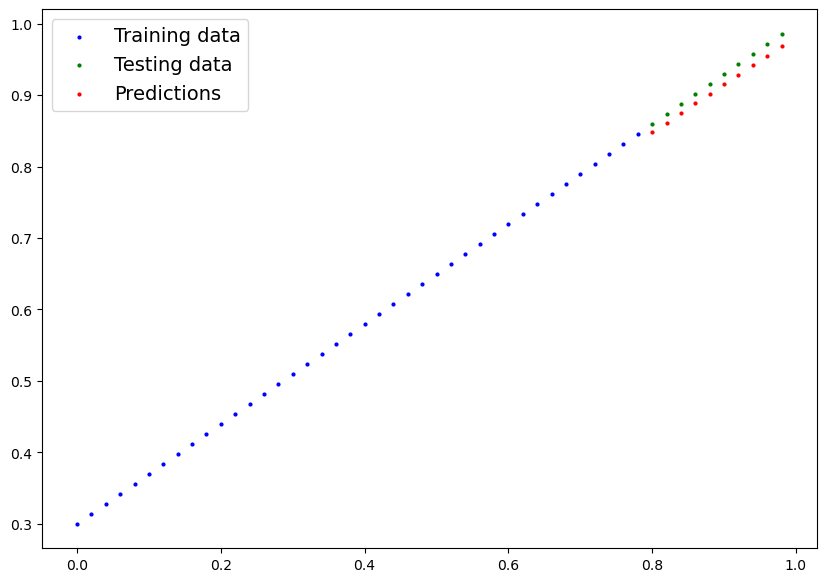

In [21]:

plot_predictions(predictions=test_preds.cpu())
model_0.state_dict()

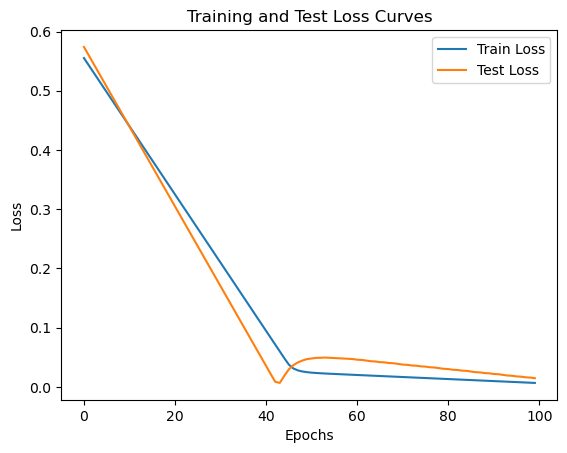

In [22]:
with torch.inference_mode():
    plt.plot(epoch_count.cpu(), train_loss_values.cpu(), label = 'Train Loss')
    plt.plot(epoch_count.cpu(), test_loss_values.cpu(), label = 'Test Loss')
    plt.title("Training and Test Loss Curves")
    plt.ylabel ('Loss')
    plt.xlabel('Epochs')
    plt.legend()

In [23]:
torch.save(obj=model_0.state_dict(), f = 'linear_regression_state.pth')

In [24]:
loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load('linear_regression_state.pth'))

loaded_model_0.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6691]])),
             ('linear_layer.bias', tensor([0.3130]))])